In [1]:
catName = 'low'

In [2]:
import sys, os, pickle, time, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from array import array

import ROOT as rt
rt.TGaxis.SetMaxDigits(4)
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import ROOT.RooFit as rf
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from histo_utilities import create_TH1D, create_TH2D, SetMaxToMaxHist
from gridVarQ2Plot import col_dic, label_dic
from progressBar import ProgressBar
from categoriesDef import categories
cat = categories[catName]

from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1


CMS_lumi.extraText = 7*' ' + 'Internal'

donotdelete = []

Welcome to JupyROOT 6.12/07


In [4]:
m_mu = 0.1056583755
m_pi = 0.13957062
m_K = 0.493677
m_D0 = 1.86483
m_Dst = 2.01026
m_jpsi = 3.096916
dm = m_Dst - m_D0

In [5]:
catText = rt.TLatex()
catText.SetTextAlign(31)
catText.SetTextSize(0.06)
catText.SetTextFont(42)
catText.SetTextSize(0.05)

In [6]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [7]:
dfRD_corr = pd.DataFrame(rtnp.root2array('../data/cmsRD/skimmed/B2DstMu_200515_{}_corr.root'.format(cat.name)))

In [8]:
dataDir = '../data/cmsRD'
datasets_loc = glob(dataDir + '/ParkingBPH*/*2018*B2DstMu_200515*')
lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
CMS_lumi.integrated_lumi = lumi_tot

Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu7_IP4_part2_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu7_IP4_part1_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu7_IP4_part4_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu7_IP4_part3_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu7_IP4_part0_v2 1.27
Total lumi: 6.39 fb^-1


In [9]:
#They all have to be produced with the same pileup
MCsample = {
'mu' : DSetLoader('B0_MuNuDmst_PUc0'),
'tau' : DSetLoader('B0_TauNuDmst_PUc0'),
# 'DstmD0' : DSetLoader('B0_DstmD0_PUc0'),
# 'DstmDp' : DSetLoader('B0_DstmDp_PUc0'),
# 'DstmDsp' : DSetLoader('B0_DstmDsp_PUc0'),
# 'BpDstmHc' : DSetLoader('Bp_DstmHc_PUc0'),
# 'BmDstmHc' : DSetLoader('Bm_DstmHc_PUc0'),
# 'antiB0DstmHc' : DSetLoader('antiB0_DstmHc_PUc0'),
# 'DstPip' : DSetLoader('Bp_MuNuDstst_Pip_PUc0'),
# 'DstPi0' : DSetLoader('B0_MuNuDstst_Pi0_PUc0'),
# 'DstPipPi0' : DSetLoader('Bp_MuNuDstst_PipPi0_PUc0'),
# 'DstPipPim' : DSetLoader('B0_MuNuDstst_PipPim_PUc0'),
# 'DstPi0Pi0' : DSetLoader('B0_MuNuDstst_Pi0Pi0_PUc0'),
}
dfMC = {}
for n, s in MCsample.iteritems():
    dfMC[n] = pd.DataFrame(rtnp.root2array(s.skimmed_dir + '/{}_corr.root'.format(cat.name)))

In [10]:
' '.join(np.sort(dfMC['mu'].columns))

'B_eta B_phi B_pt D0_eta D0_phi D0_pt Dst_eta Dst_phi Dst_pt Est_mu K_eta K_phi K_pt M2_miss MC_B_eta MC_B_phi MC_B_pt MC_DstMotherPdgId MC_DstSisterPdgId_heavy MC_DstSisterPdgId_light MC_Dst_eta MC_Dst_phi MC_Dst_pt MC_Est_mu MC_K_eta MC_K_phi MC_K_pt MC_M2_miss MC_idxMatch MC_muMotherPdgId MC_mu_IP MC_mu_eta MC_mu_phi MC_mu_pt MC_munuSisterPdgId MC_pi_eta MC_pi_phi MC_pi_pt MC_pis_eta MC_pis_phi MC_pis_pt MC_q2 MC_tkFlag_0 MC_tkFlag_1 MC_tkMotherMotherPdgId_0 MC_tkMotherMotherPdgId_1 MC_tkMotherPdgId_0 MC_tkMotherPdgId_1 MC_tkPdgId_0 MC_tkPdgId_1 MC_tk_deta_0 MC_tk_deta_1 MC_tk_dphi_0 MC_tk_dphi_1 MC_tk_dpt_0 MC_tk_dpt_1 N_goodAddTks N_vtx U_miss cat_high cat_low cat_mid cosT_D0pismu_PV cos_D0pismu_PV index localVertexDensity mass_D0pis mass_D0pismu mass_piK muPass_Mu12_IP6 muPass_Mu7_IP4 muPass_Mu9_IP6 mu_eta mu_phi mu_pt mu_sigdxy pi_eta pi_phi pi_pt pis_eta pis_phi pis_pt pval_D0pis pval_D0pismu pval_piK q2 sigdxy_vtxD0_PV tkCharge_0 tkCharge_1 tkEta_0 tkEta_1 tkMassHad12 tkMassHa

# B reco resolution on MC

In [11]:
CMS_lumi.integrated_lumi = None
CMS_lumi.extraText = 7*' ' + 'Simulation'

Inside fraction 0.986
dPhi width 7.29e-03
dEta width 9.86e-03


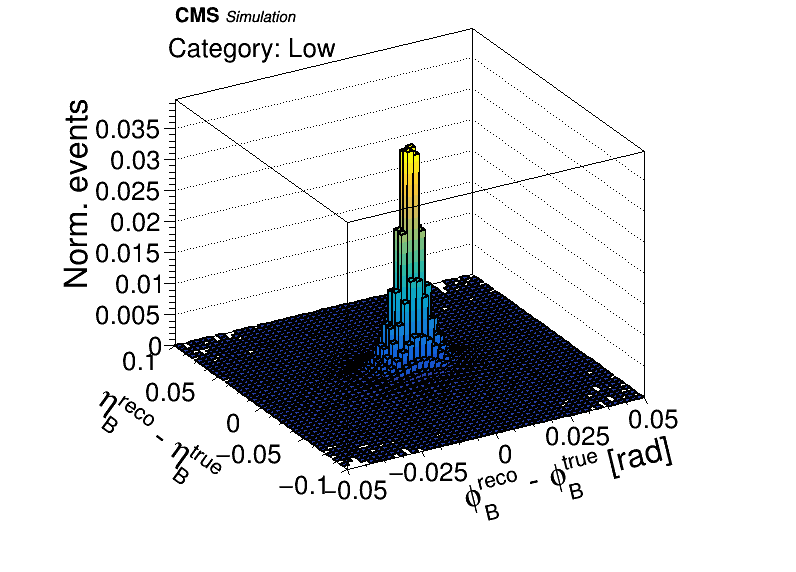

In [12]:
deta = dfMC['mu']['B_eta'] - dfMC['mu']['MC_B_eta']
dphi = dfMC['mu']['B_phi'] - dfMC['mu']['MC_B_phi']
dphi = np.where(np.abs(dphi) > np.pi, dphi - np.sign(dphi)*2*np.pi, dphi)
sel = np.logical_and(np.abs(dphi) < 0.05, np.abs(deta) < 0.1) 
print 'Inside fraction {:.3f}'.format(np.sum(sel)/float(sel.shape[0]))
print 'dPhi width {:1.2e}'.format(0.5*(np.percentile(dphi, 84) - np.percentile(dphi, 16)))
print 'dEta width {:1.2e}'.format(0.5*(np.percentile(deta, 84) - np.percentile(deta, 16)))
h = create_TH2D(np.column_stack((dphi, deta)), 
                binning=[50, -0.05, 0.05, 50, -0.1, 0.1],
                axis_title=['#phi_{B}^{reco} - #phi_{B}^{true} [rad]', '#eta_{B}^{reco} - #eta_{B}^{true}', 'Norm. events'],
               )
h.Scale(1./dphi.shape[0])
h.GetXaxis().SetNdivisions(-404)
h.GetYaxis().SetNdivisions(-404)
h.GetXaxis().SetTitleOffset(1.3)
h.GetYaxis().SetTitleOffset(1.7)
h.GetZaxis().SetTitleOffset(1.3)
C = drawOnCMSCanvas(CMS_lumi, [h], ['LEGO2 0'], mL=0.22, mR=0.19, mB=0.18)
catText.DrawLatexNDC(0.43, 0.9, 'Category: {}'.format(cat.name))

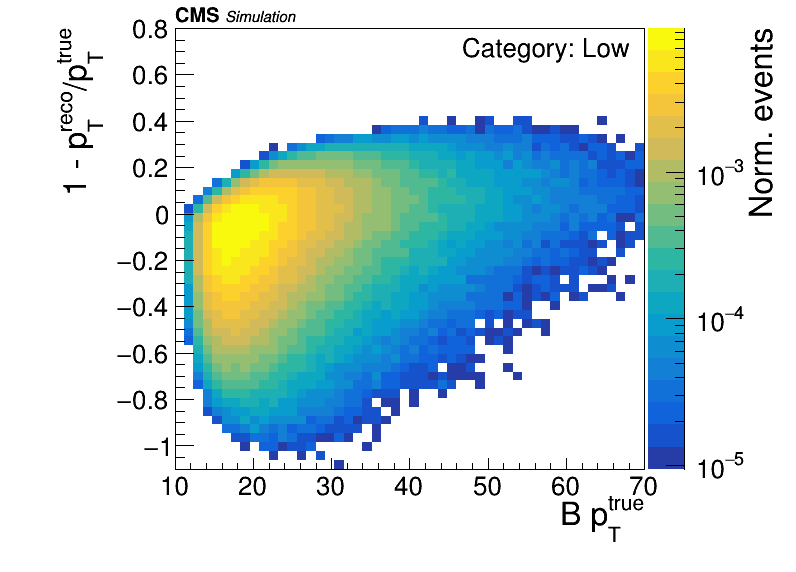

In [13]:
h = create_TH2D(np.column_stack((dfMC['mu']['MC_B_pt'], 1 - dfMC['mu']['B_pt']/dfMC['mu']['MC_B_pt'])), 
                binning=[50, 10, 70, 50, -1.1, .8],
                axis_title=['B p_{T}^{true}', '1 - p_{T}^{reco}/p_{T}^{true}', 'Norm. events'],
               )
h.Scale(1./dfMC['mu']['B_pt'].shape[0])
# h.GetXaxis().SetNdivisions(-404)
# h.GetYaxis().SetNdivisions(-404)
# h.GetXaxis().SetTitleOffset(1.20)
# h.GetYaxis().SetTitleOffset(1.7)
# h.GetZaxis().SetTitleOffset(1.3)
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mL=0.22, mR=0.19, mB=0.18)
c.SetLogz()
catText.DrawLatexNDC(0.8, 0.9, 'Category: {}'.format(cat.name))

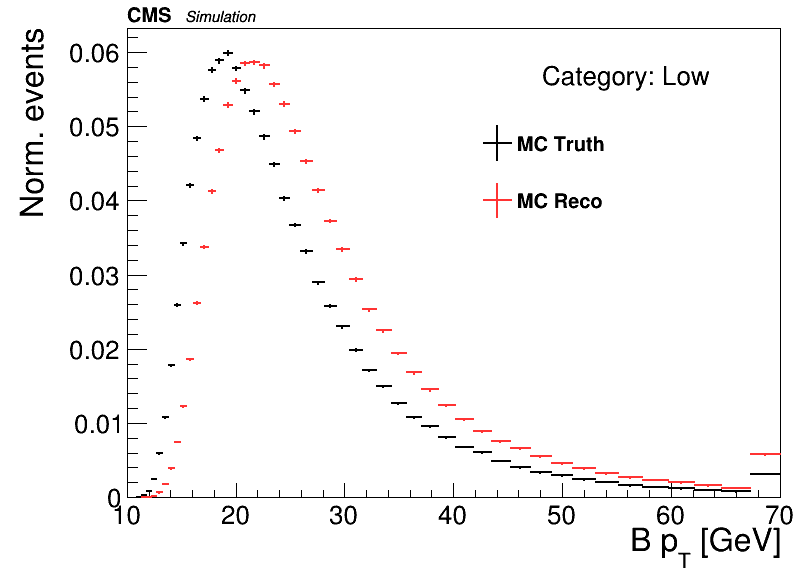

In [19]:
h1 = create_TH1D(dfMC['mu']['MC_B_pt'], 
#                  binning=[50, 10, 150],
                 binning=np.logspace(1, np.log10(70), 50),
                 opt='overflow',
                 axis_title=['B p_{T} [GeV]', 'Norm. events'],
                 scale_histo='norm'
                )
h2 = create_TH1D(dfMC['mu']['B_pt'], binning=h1.binning,
                 opt='overflow',
                 scale_histo='norm',
                 color=1
                )

leg = rt.TLegend(0.6, 0.6, 0.8, 0.8)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.AddEntry(h1, 'MC Truth', 'lep')
leg.AddEntry(h2, 'MC Reco', 'lep')
    
c = drawOnCMSCanvas(CMS_lumi, [h1, h2], 'same')
catText.DrawLatexNDC(0.9, 0.85, 'Category: {}'.format(cat.name))
leg.Draw()

# Kinematics variables plots

In [15]:
def plotKinVar(var, binning=[50, -2, 12], 
               xtitle='q^{2} [GeV^{2}]', 
               legLoc=[0.2, 0.62, 0.55, 0.9], 
               drawLeg=True,
               textLoc=[0.94, 0.9]):
    h1 = create_TH1D(dfMC['mu']['MC_'+var], 
                     binning=binning,
                     opt='overflow+underflow',
                     axis_title=[xtitle, 'Norm. events / {:.2f}'.format((binning[2]-binning[1])/float(binning[0]))],
                     scale_histo='norm',
                     color=0
                    )
    h1.Sumw2(0)
    h1.SetLineStyle(7)
    h1.SetFillStyle(0)

    h2 = create_TH1D(dfMC['mu'][var], binning=h1.binning,
                     opt='overflow+underflow',
                     scale_histo='norm',
                     color=0
                    )

    h3 = create_TH1D(dfMC['tau']['MC_'+var], binning=h1.binning,
                     opt='overflow+underflow',
                     scale_histo='norm',
                     color=1
                    )
    h3.Sumw2(0)
    h3.SetLineStyle(7)
    h3.SetFillStyle(0)

    h4 = create_TH1D(dfMC['tau'][var], binning=h1.binning,
                     opt='overflow+underflow',
                     scale_histo='norm',
                     color=1
                    )

    leg = rt.TLegend(legLoc[0], legLoc[1], legLoc[2], legLoc[3])
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    leg.AddEntry(h1, 'MC Truth, '+label_dic['mu'], 'lep')
    leg.AddEntry(h2, 'MC Reco, '+label_dic['mu'], 'lep')
    leg.AddEntry(h3, 'MC Truth, '+label_dic['tau'], 'lep')
    leg.AddEntry(h4, 'MC Reco, '+label_dic['tau'], 'lep')

    hlist = [h1, h2, h3, h4]
    SetMaxToMaxHist(hlist)
    c = drawOnCMSCanvas(CMS_lumi, hlist, 'same')
    catText.DrawLatexNDC(textLoc[0], textLoc[1], 'Category: {}'.format(cat.name))
    if drawLeg:
        leg.Draw()
    
    c.dnd = [hlist, leg]
    return c

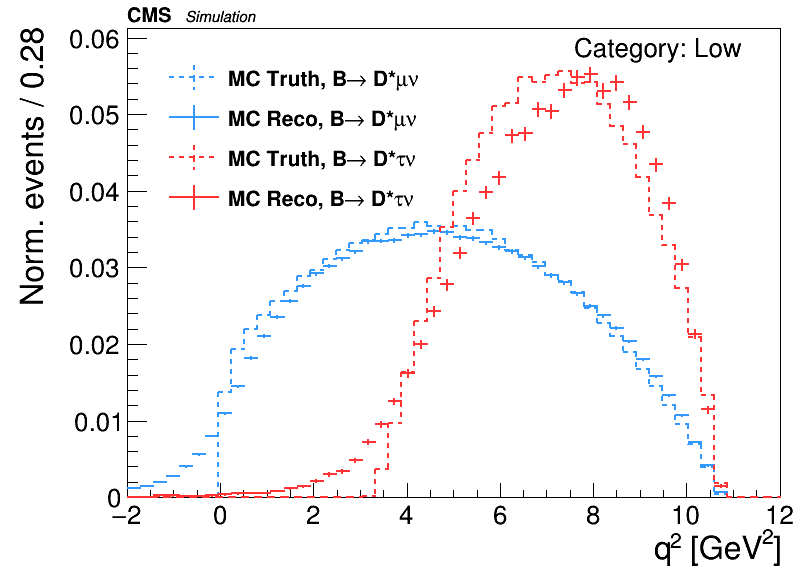

In [16]:
plotKinVar('q2');

<ROOT.TCanvas object ("c") at 0xbe05030>

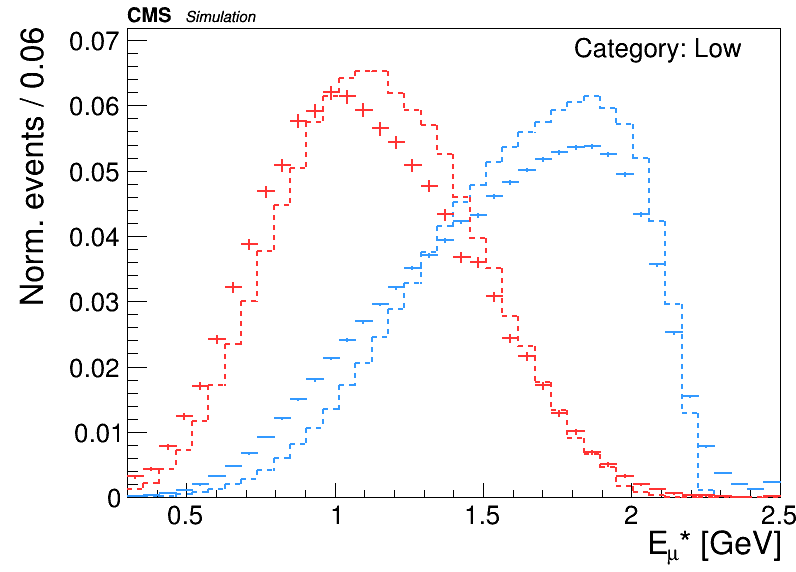

In [17]:
plotKinVar('Est_mu', binning=[40, 0.3, 2.5], xtitle='E_{#mu}* [GeV]', drawLeg=0)

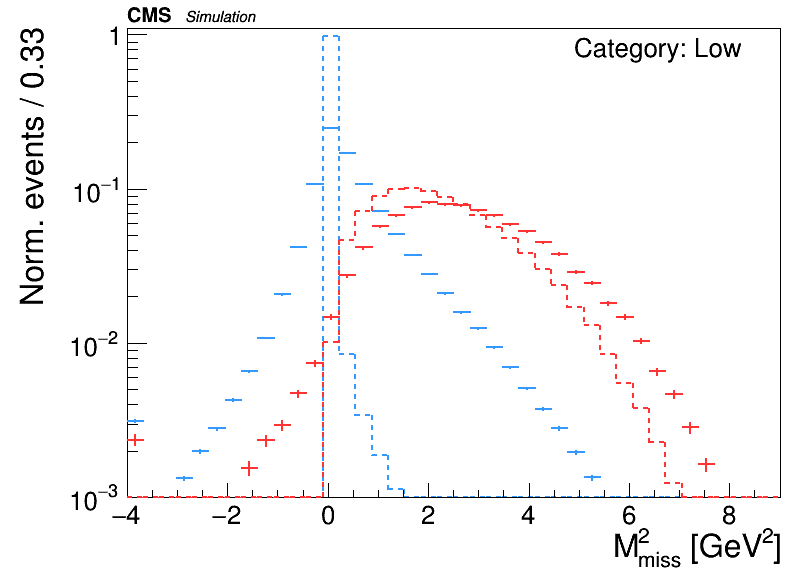

In [18]:
c = plotKinVar('M2_miss', binning=[40, -4, 9], xtitle='M^{2}_{miss} [GeV^{2}]', drawLeg=0)
c.dnd[0][0].GetYaxis().SetRangeUser(1e-3, 1.1)
c.SetLogy()